# Importing Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, date_format, sum, count, date_trunc
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np

# Building Spark Session and capturing kafka data stream

In [2]:
spark = SparkSession.builder \
    .appName("KafkaDataSparkAnalysis") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

kafka_broker = "44.201.154.178:9092"
topic = "health_events"

kafka_source = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", topic) \
    .option("startingOffsets", "earliest") \
    .load()

In [3]:
defined_schema = StructType([
    StructField("EventType", StringType()),
    StructField("Timestamp", TimestampType()),
    StructField("Location", StringType()),
    StructField("Severity", StringType()),
    StructField("Details", StringType())
])

kafka_stream = kafka_source.selectExpr("CAST(value AS STRING)")  
kafka_stream = kafka_stream.select(from_json("value", defined_schema).alias("data")).select("data.*")
kafka_stream

DataFrame[EventType: string, Timestamp: timestamp, Location: string, Severity: string, Details: string]

In [4]:
query = kafka_stream \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("health_events_stream") \
    .start()

# Wait for the stream to finish
# query.awaitTermination()
# Wait to collect all data then stop instead of waiting forever
time.sleep(30)
query.stop()

In [5]:
df = spark.sql("SELECT * FROM health_events_stream")
df.show(5)

+------------------+-------------------+--------+--------+--------------------+
|         EventType|          Timestamp|Location|Severity|             Details|
+------------------+-------------------+--------+--------+--------------------+
|       vaccination|2024-05-01 02:14:49|  London|     low|This is a simulat...|
|emergency_incident|2024-05-01 02:14:56|   Paris|    high|This is a simulat...|
|emergency_incident|2024-05-01 02:15:13|  Boston|    high|This is a simulat...|
|    health_mention|2024-05-01 02:15:18|  Berlin|     low|This is a simulat...|
|    health_mention|2024-05-01 02:15:35|   Paris|     low|This is a simulat...|
+------------------+-------------------+--------+--------+--------------------+
only showing top 5 rows



# Exploratory Data Analysis (EDA)

In [6]:
df.printSchema()

root
 |-- EventType: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Details: string (nullable = true)



In [7]:
print("Number of rows:", df.count())

Number of rows: 53002


In [8]:
# EventType Distribution
df.groupBy('EventType') \
   .count() \
   .orderBy('count', ascending=False).toPandas()

,EventType,count
0,health_mention,8907
1,hospital_admission,8884
2,vaccination,8856
3,routine_checkup,8800
4,general_health_report,8792
5,emergency_incident,8763


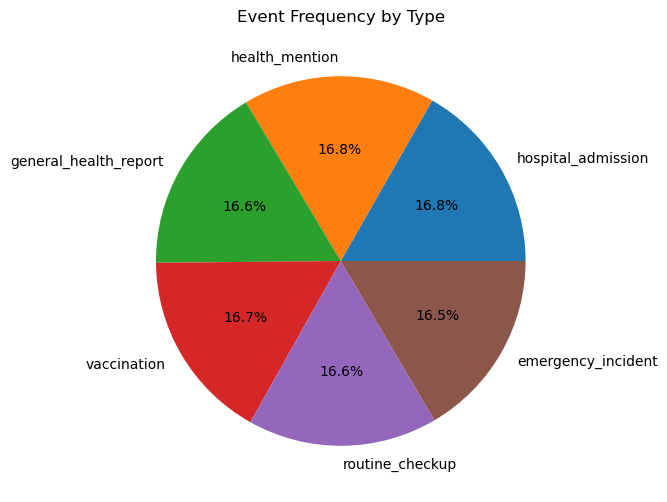

In [9]:
event_counts = df.groupBy("EventType").count()
event_counts_pd = event_counts.toPandas()
# Visualization of Event Frequency by Type using a Pie Chart
plt.figure(figsize=(12, 6))
event_counts_pd.set_index('EventType')['count'].plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')  # Remove y-label as it's unnecessary for pie charts
plt.title('Event Frequency by Type')
plt.show()

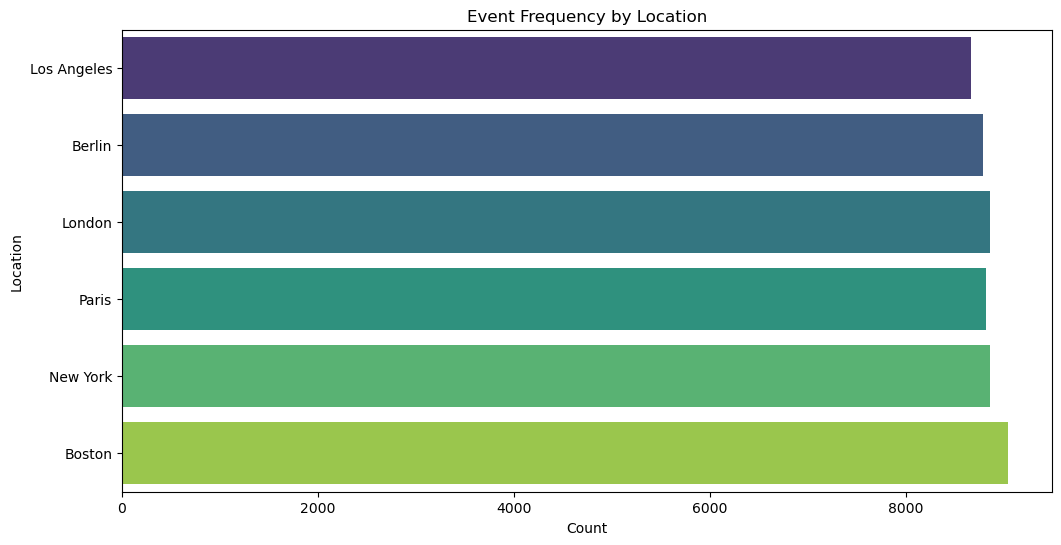

In [10]:
location_counts = df.groupBy("Location").count()
location_counts_pd = location_counts.toPandas()
# Visualization of Event Count by Location using Horizontal Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=location_counts_pd, y='Location', x='count', palette='viridis')
plt.ylabel('Location')
plt.xlabel('Count')
plt.title('Event Frequency by Location')
plt.show()

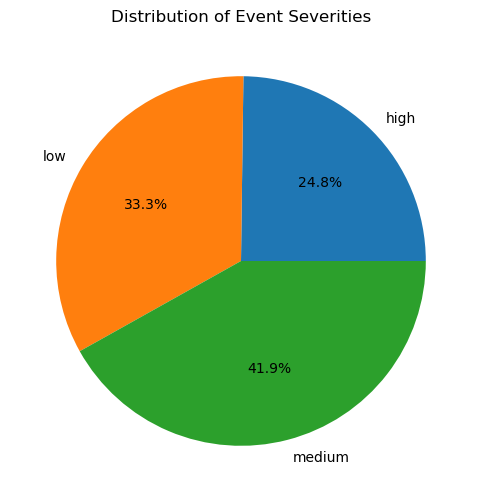

In [11]:
severity_counts = df.groupBy('Severity').count().orderBy('Severity')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
severity_counts_pandas = severity_counts.toPandas()

# Plot the distribution of event severities using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(severity_counts_pandas['count'], labels=severity_counts_pandas['Severity'], autopct='%1.1f%%')
plt.title('Distribution of Event Severities')
plt.show()

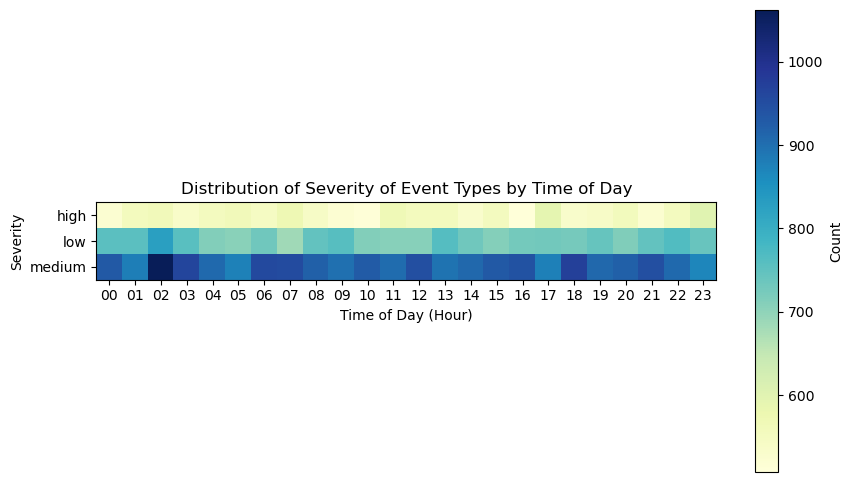

In [12]:
# Ensure 'Timestamp' column is in timestamp format
df = df.withColumn('Timestamp', col('Timestamp').cast('timestamp'))

# Extract hour and severity columns
df = df.withColumn('Hour', date_format(col('Timestamp'), 'HH'))

# Filter events with 'low', 'medium', or 'high' severity
df_filtered = df.filter(col('Severity').isin('low', 'medium', 'high'))

# Group by hour and severity, and count occurrences
severity_distribution = df_filtered.groupBy('Hour', 'Severity').count().orderBy('Hour', 'Severity')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
severity_distribution_pandas = severity_distribution.toPandas()

# Create a pivot table for heatmap-like visualization
pivot_table = severity_distribution_pandas.pivot(index='Severity', columns='Hour', values='count')

# Plot the transposed heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pivot_table, cmap='YlGnBu', interpolation='nearest')

# Add labels and title
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Severity')
plt.title('Distribution of Severity of Event Types by Time of Day')
plt.colorbar(label='Count')

# Customize tick labels
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# Show plot
plt.show()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


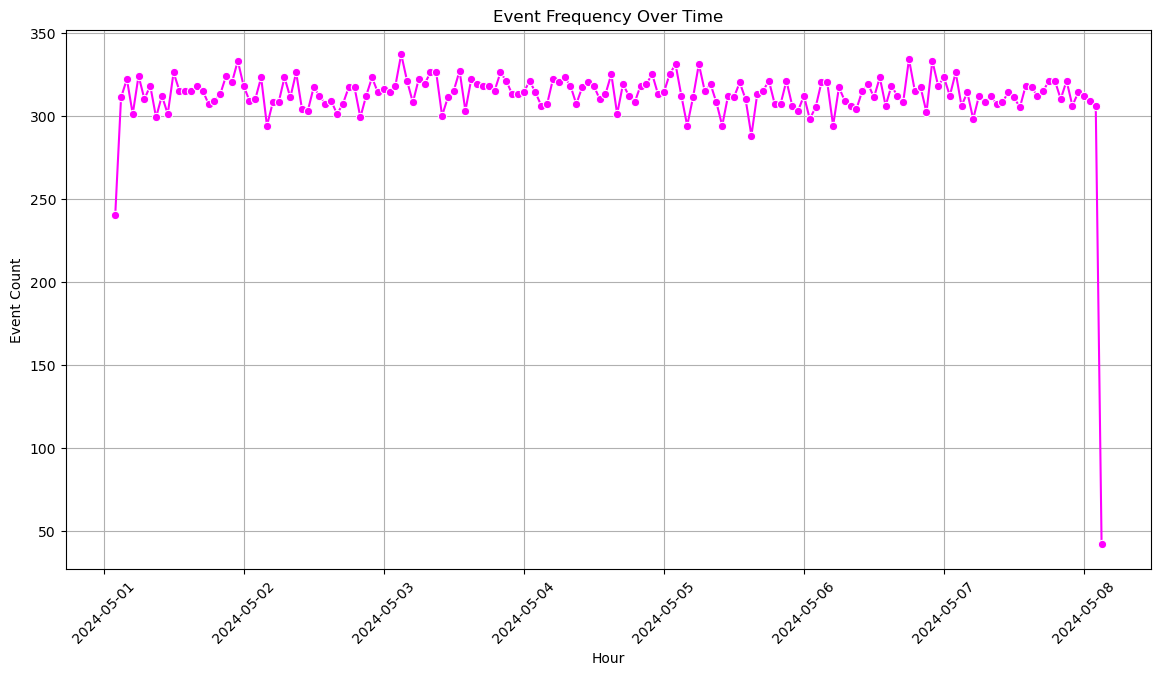

/tmp/ipykernel_99/648129868.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  event_type_location_matrix = event_type_location_pd.pivot("EventType", "Location", "count")


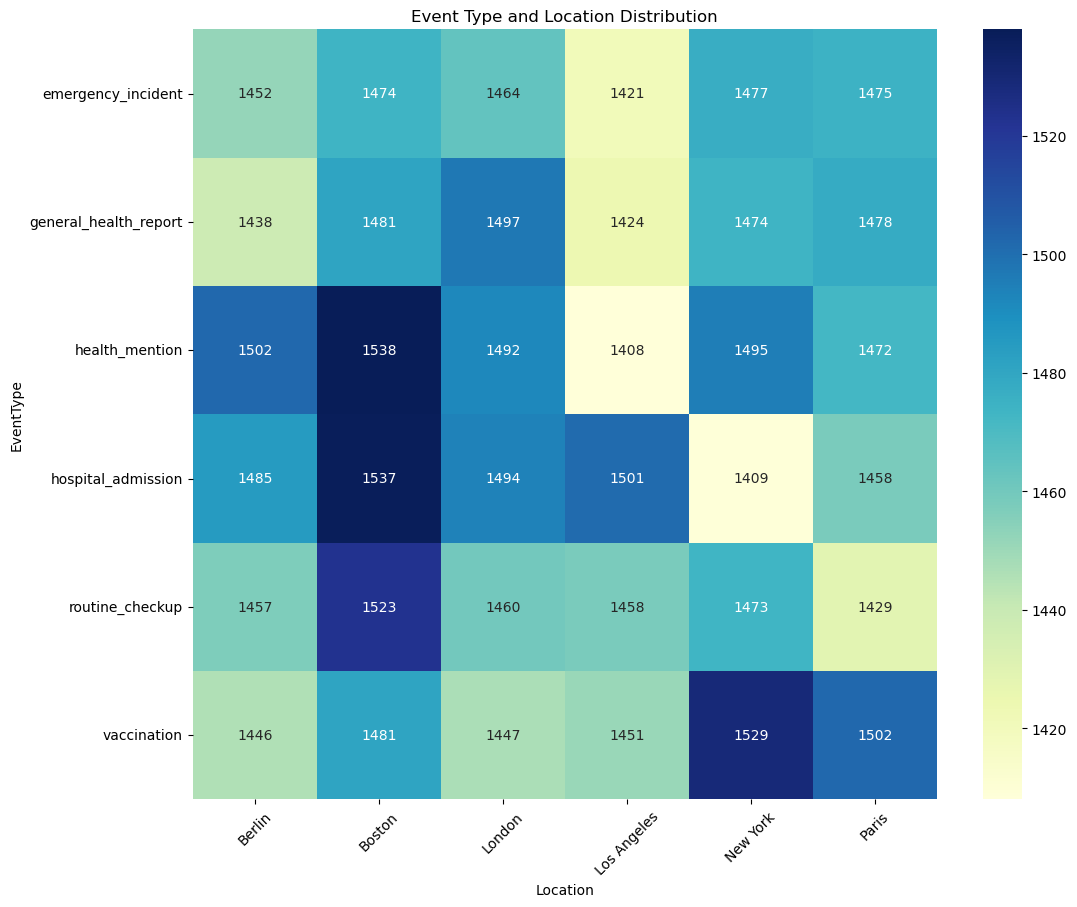

In [13]:
event_time_distribution = df.groupBy(date_trunc('hour', col("Timestamp")).alias("Hour")).count().orderBy("Hour")
event_type_location_distribution = df.groupBy("EventType", "Location").count()

event_time_pd = event_time_distribution.toPandas()
event_type_location_pd = event_type_location_distribution.toPandas()

# Visualization of Event Frequency Over Time using Line Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=event_time_pd, x='Hour', y='count', marker='o', color='magenta')
plt.title('Event Frequency Over Time')
plt.xlabel('Hour')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualization of Event Type Relationships: Count of each event type by location using Heatmap
event_type_location_matrix = event_type_location_pd.pivot("EventType", "Location", "count")
plt.figure(figsize=(12, 10))
sns.heatmap(event_type_location_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Event Type and Location Distribution')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

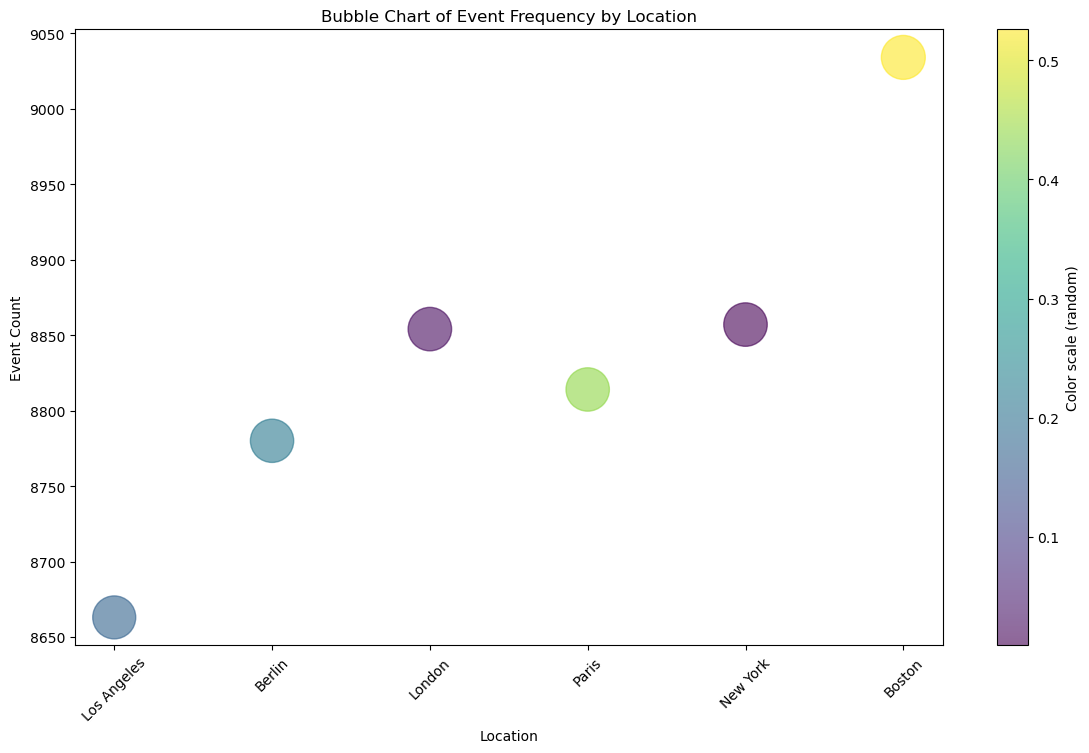

In [14]:
# Enhanced Visualization of Event Count by Location using Bubble Chart
colors = np.random.rand(len(location_counts_pd))  # Random colors; you could map this to a colormap instead
sizes = location_counts_pd['count'] / location_counts_pd['count'].max() * 1000  # Example scaling

plt.figure(figsize=(14, 8))
scatter = plt.scatter(location_counts_pd['Location'], location_counts_pd['count'], s=sizes, c=colors, alpha=0.6, cmap='viridis')
plt.xlabel('Location')
plt.ylabel('Event Count')
plt.title('Bubble Chart of Event Frequency by Location')
plt.xticks(rotation=45)
plt.colorbar(scatter, label='Color scale (random)')  # Only useful if colors mean something
plt.show()